 # Week 8: Exercise 8.2
 File: DSC530_Paulovici_Exercise_8.2.py (.ipynb)<br>
 Name: Kevin Paulovici<br>
 Date: 10/20/2019<br>
 Course: DSC 530 Data Exploration and Analysis<br>
 Assignment: Chapter 9: 9.1 & Chapter 10: 10.1

In [1]:
import numpy as np
import pandas as pd

import first
import hypothesis
import thinkstats2

import scatter
import brfss
import thinkplot


 ## Chapter 9

 ### Exercise 9.1
 As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real. <br> <br>
 To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows in a DataFrame. <br> <br>
 What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [2]:
# set up functions to run the samples
class DiffMeans(hypothesis.DiffMeansPermute):
    """ Test a diff in means """

    def RunModel(self):
        """ Run model for null hypothesis """

        g1 = np.random.choice(self.pool, self.n, replace=True)
        g2 = np.random.choice(self.pool, self.m, replace=True)

        return g1, g2

def RunSampleTest(first, others):
    """ Test diff in mean 
    
    @param: first (dataframe) - first babies data
    @param: first (dataframe) - other babies data
    """
    # test for baby length
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeans(data)
    pVal = ht.PValue(iters=10000)

    print("\nMeans permute pregnancy length")
    print("P Value: {:.3f}".format(pVal))
    print("Actual: {:.3f}".format(ht.actual))
    print("T-test max: {:.3f}".format(ht.MaxTestStat()))

    # test for baby weight
    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = hypothesis.DiffMeansPermute(data)
    pVal = ht.PValue(iters=10000)
    print("\nMeans permute birthweight")
    print("P Value: {:.3f}".format(pVal))
    print("Actual: {:.3f}".format(ht.actual))
    print("T-test max: {:.3f}".format(ht.MaxTestStat()))

def RunTests(live, iters=1000):
    """ Run tests from chap 9 

    @param: live (datafram) - live births
    @param: iters (int) - # of iterations 
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = hypothesis.DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = hypothesis.CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = hypothesis.PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print("{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format(n, p1, p2, p3, p4))


In [3]:
# set the random generators
thinkstats2.RandomSeed(18)

# get the wght and length 
live, firsts, others = first.MakeFrames()
RunSampleTest(first, others)



Means permute pregnancy length
P Value: 0.167
Actual: 0.078
T-test max: 0.227

Means permute birthweight
P Value: 0.000
Actual: 0.125
T-test max: 0.112


In [4]:
# run the test
n = len(live)
print("nval\t Test1\t  Test2\t  Test3\t  Test4\t")
for i in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2


nval	 Test1	  Test2	  Test3	  Test4	
9148	0.156	0.000	0.000	0.000
4574	0.025	0.022	0.000	0.000
2287	0.037	0.070	0.001	0.000
1143	0.703	0.042	0.797	0.067
571	0.527	0.001	0.000	0.347
285	0.959	0.842	0.350	0.531
142	0.872	0.488	0.200	0.063


 Generally we positive test become negative as the sample size decreases.

 ## Chapter 10

 ### Exercise 10.1
 Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?
 <br> <br> Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

In [5]:
# read in the brfss data
data = brfss.ReadBrfss(nrows=None)
data = data.dropna(subset=['htm3', 'wtkg2'])

weights = data.wtkg2
heights = data.htm3

# get log weight
logWeight = np.log10(weights)


In [6]:
# Estimate intercept and slope
inter, slope = thinkstats2.LeastSquares(heights, logWeight)

print("intercept: {:.3f} \n slope: {:.3f}".format(inter, slope))


intercept: 0.993 
 slope: 0.005


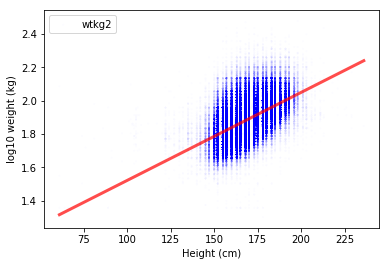

In [7]:
# show scatter plot of fitted line
thinkplot.Scatter(heights, logWeight, alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, inter, slope)
thinkplot.Plot(fxs, fys, color='red')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)')


In [8]:
# get the residuals
res = thinkstats2.Residuals(heights, logWeight, inter, slope)
data['residual'] = res


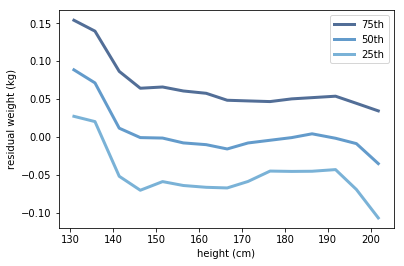

In [9]:
# set up bins, indicies, and groups to calc mean and cdf
bins = np.arange(130, 210, 5)
indices = np.digitize(data.htm3, bins)
groups = data.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

# plot the pencitles
for p in [75, 50, 25]:
    ys = [cdf.Percentile(p) for cdf in cdfs]
    label = str(p) + 'th'
    thinkplot.Plot(means, ys, label=label)

thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)')


In [10]:
# calculate correlation and coefficient of determination
rho = thinkstats2.Corr(heights, logWeight)
r2 = thinkstats2.CoefDetermination(logWeight, res)

# check if R^2 = rho^2
print("Correlation: {:.3f}".format(rho))
print("Coefficent of determination: {:.3f}".format(r2)) 

print("R^2 - rho^2: {:.3f}".format(rho**2 - r2))


Correlation: 0.532
Coefficent of determination: 0.283
R^2 - rho^2: 0.000


In [11]:
# calc standard deviation (RMSE) of prediction w/o height
std_ys = thinkstats2.Std(logWeight)
print("Standard deviation w/o height: {:.3f}".format(std_ys))


Standard deviation w/o height: 0.103


In [12]:
# calc standard deviation (RMSE) of prediction w/ height
std_res = thinkstats2.Std(res)
print("Standard deviation w/ height: {:.3f}".format(std_res))



Standard deviation w/ height: 0.087


In [13]:
# How does RMSE get impacted by height info
print("Impact: {:.3f}".format(1 - (std_res/std_ys)))


Impact: 0.153


In [14]:
# Resampling to compute inter and slope
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(data)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)


{'xscale': 'linear', 'yscale': 'linear'}

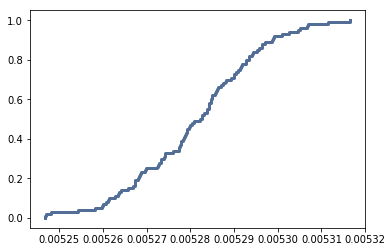

In [15]:
# Plot the sampling distribution of slope.
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)


In [16]:
# Compute the p-value of the slope.
pvalue = cdf[0]
pvalue


0

In [17]:
# 90% confidence interval of slope
ci = cdf.Percentile(5), cdf.Percentile(95)
ci


(0.005258099751410994, 0.005304748531528853)

In [18]:
# get the mean of the new sampling dist.
mean = thinkstats2.Mean(slopes)
mean


0.0052810744138255105

In [19]:
# Compute the standard deviation of the sampling distribution, which is the standard error.
stderr = thinkstats2.Std(slopes)
stderr


1.4197094551197431e-05

In [22]:
# From ThinkStats
# The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.
def Summarize(estimates, actual=None):
    mean = thinkstats2.Mean(estimates)
    stderr = thinkstats2.Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean: {:.3f} SE: {:.3f} CI: {}'.format(mean, stderr, ci))


In [23]:
# Resample rows without weights, compute mean height, and summarize results.
estimates_unweighted = [thinkstats2.ResampleRows(data).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)


mean: 168.955 SE: 0.017 CI: (168.9222599486651, 168.98246225671497)


In [24]:
# From ThinkStats
def ResampleRowsWeighted(data, column='finalwgt'):
    weights = data[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = data.loc[indices]
    return sample


In [ ]:
# Resample rows with weights.
estimates_weighted = [ResampleRowsWeighted(data, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)